In [ ]:
import pandas as pd
import os

import sys
sys.path.append('../scripts')

from plot_functions import plot_job_summary_violin, plot_util_dist, plot_power_dist, plot_energy_dist,  plot_tif_dist, plot_sif_dist, plot_ai_dist


In [ ]:
vasp_data = pd.read_parquet('../VASP_march_jobs.parquet')


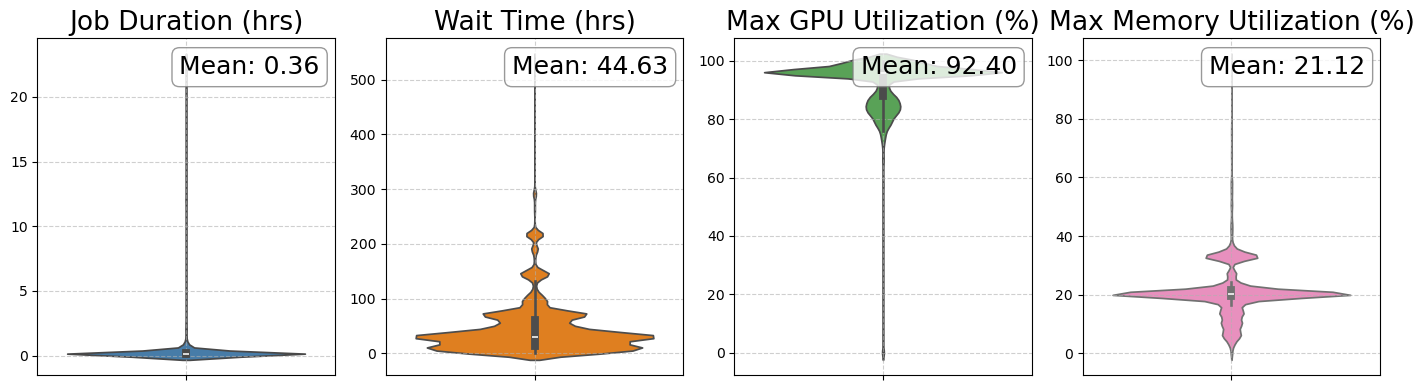

In [3]:
plot_job_summary_violin(vasp_data)

CDF and PDF Plots

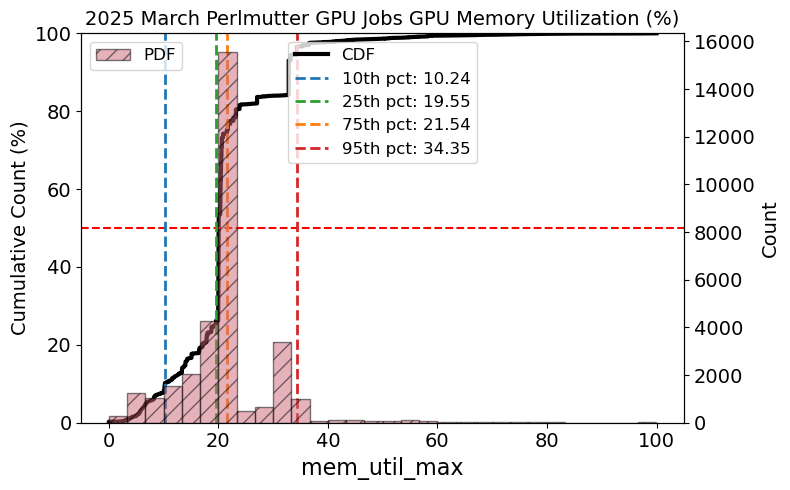

In [4]:
plot_util_dist(vasp_data, 'mem_util_max', '2025 March Perlmutter GPU Jobs GPU Memory Utilization (%)',color='#CC6677')  



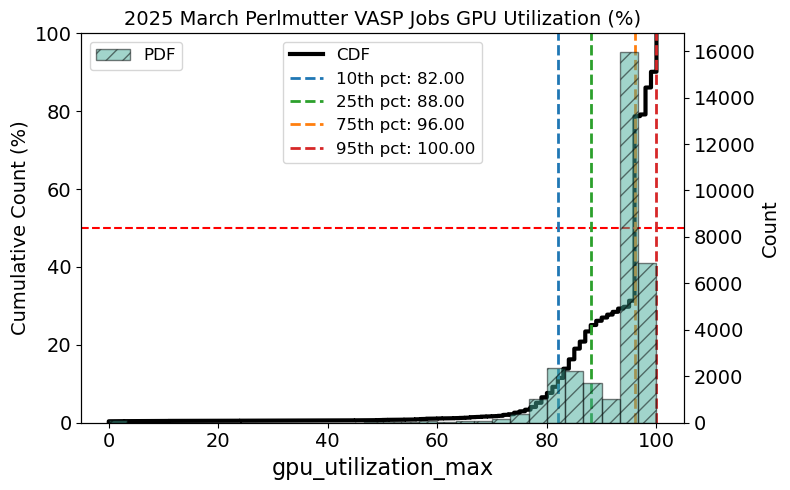

In [5]:
plot_util_dist(vasp_data, 'gpu_utilization_max', '2025 March Perlmutter VASP Jobs GPU Utilization (%)',color='#44AA99')  


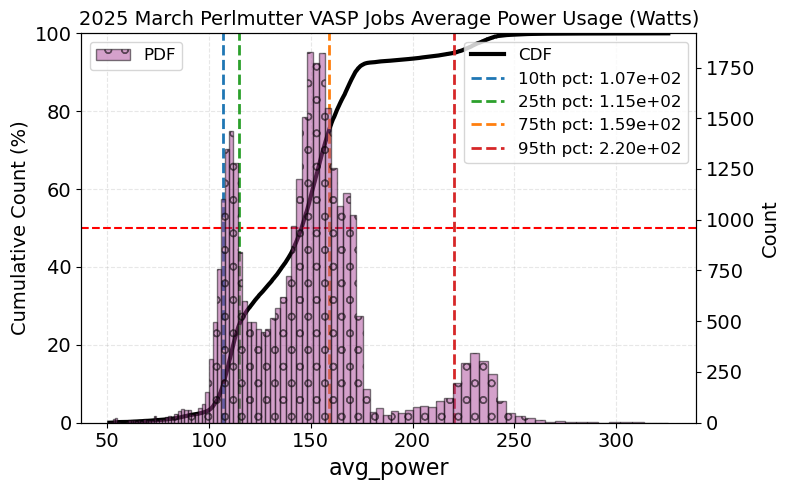

In [6]:
power_df = vasp_data[vasp_data['avg_power'] < 1e3] # disregarding the tail
plot_power_dist(power_df, 'avg_power', '2025 March Perlmutter VASP Jobs Average Power Usage (Watts)', color="#AA4499")


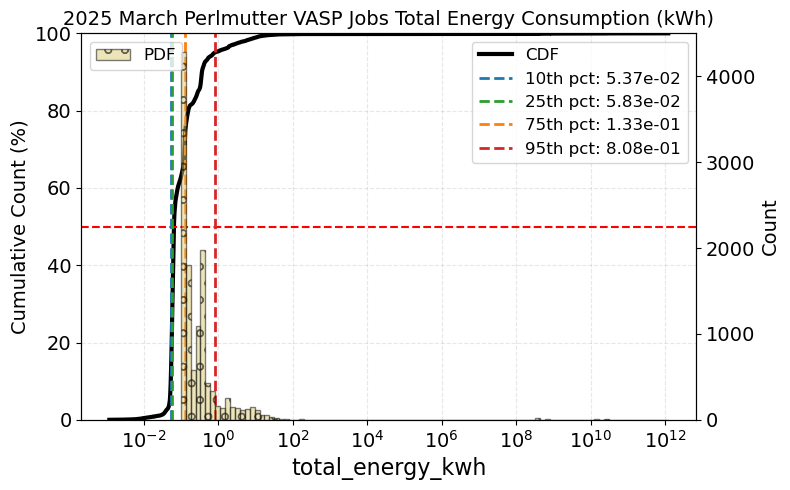

In [7]:
plot_energy_dist(vasp_data, 'total_energy_kwh', '2025 March Perlmutter VASP Jobs Total Energy Consumption (kWh)', color="#DDCC77")


AI Metric Visualization

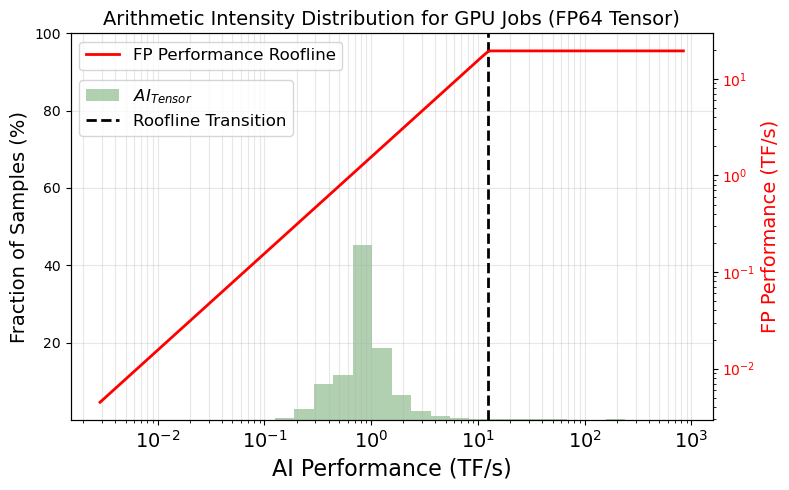

In [8]:
plot_ai_dist(vasp_data, 'AI_tensor', 'Arithmetic Intensity Distribution for GPU Jobs (FP64 Tensor)', r'$AI_{Tensor}$', color = 'darkseagreen')


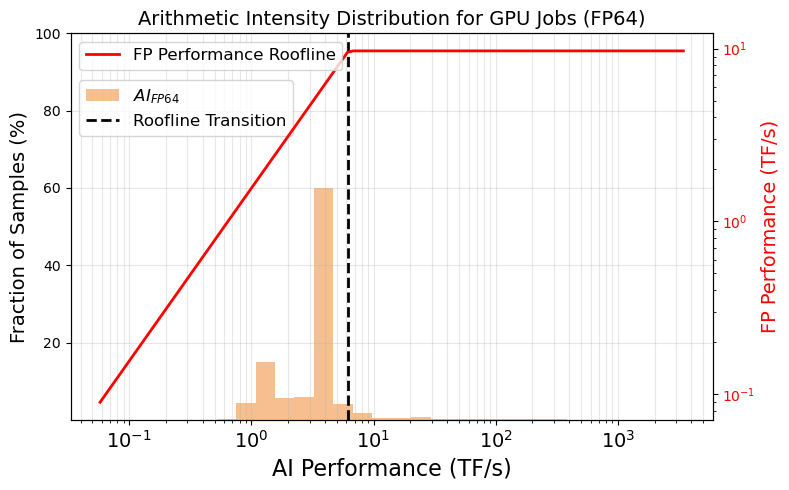

In [9]:
plot_ai_dist(vasp_data, 'AI_fp64', 'Arithmetic Intensity Distribution for GPU Jobs (FP64)', r'$AI_{FP64}$', color = 'sandybrown')


Visualize Temporal Imbalance Factors

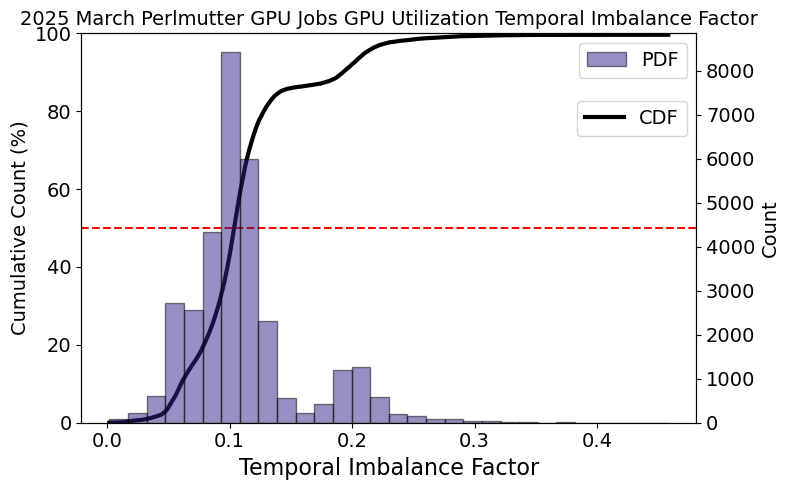

In [10]:
plot_tif_dist(vasp_data, 'gpu_tif_merged', '2025 March Perlmutter GPU Jobs GPU Utilization Temporal Imbalance Factor')


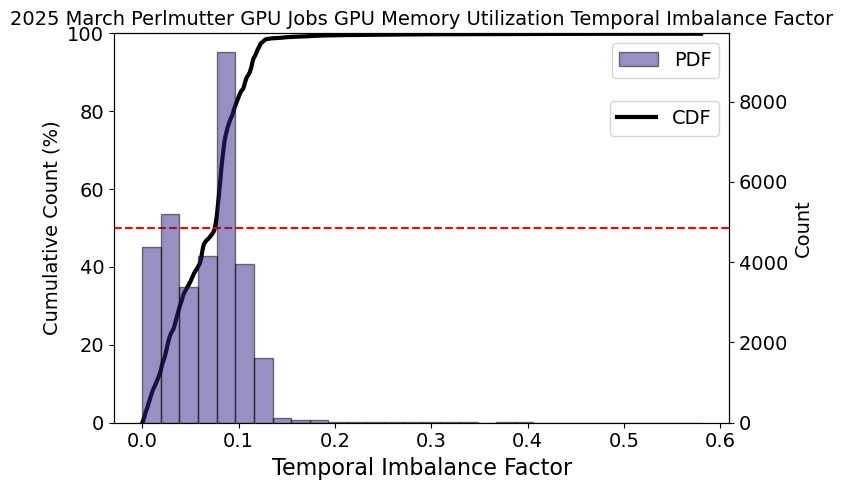

In [11]:
plot_tif_dist(vasp_data, 'mem_tif_merged', '2025 March Perlmutter GPU Jobs GPU Memory Utilization Temporal Imbalance Factor')


Visualize Spatial Imbalance Factors

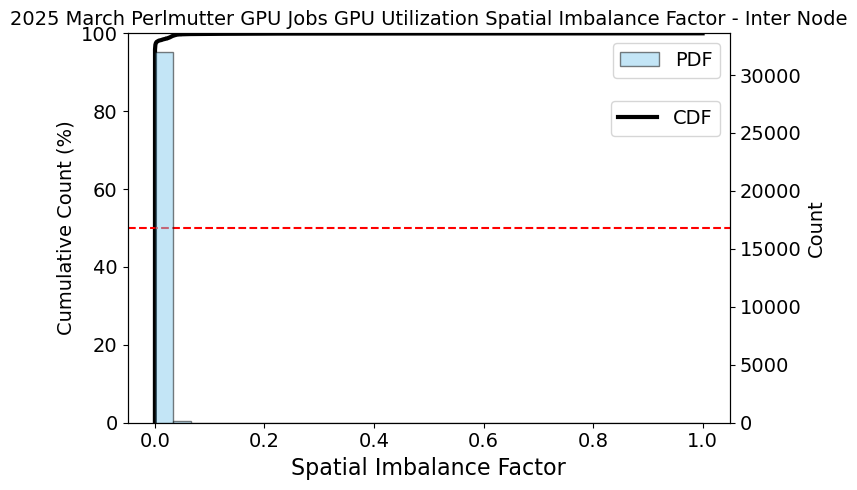

In [12]:
plot_sif_dist(vasp_data, 'gpu_sif_inter_normalized', '2025 March Perlmutter GPU Jobs GPU Utilization Spatial Imbalance Factor - Inter Node')



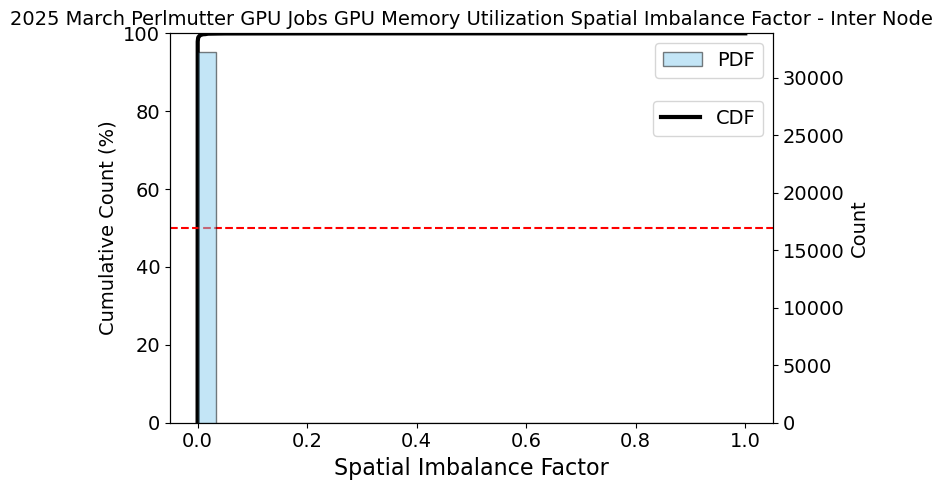

In [13]:
plot_sif_dist(vasp_data, 'mem_sif_inter_normalized', '2025 March Perlmutter GPU Jobs GPU Memory Utilization Spatial Imbalance Factor - Inter Node')


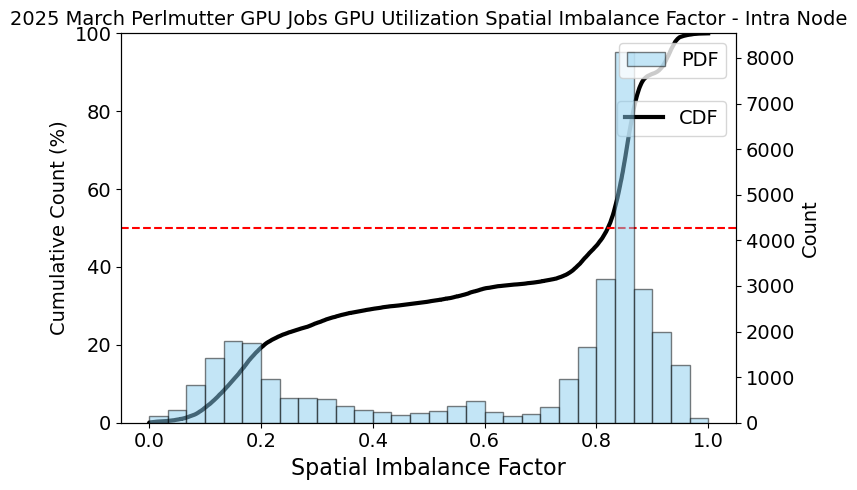

In [14]:
plot_sif_dist(vasp_data, 'gpu_sif_intra_normalized', '2025 March Perlmutter GPU Jobs GPU Utilization Spatial Imbalance Factor - Intra Node')



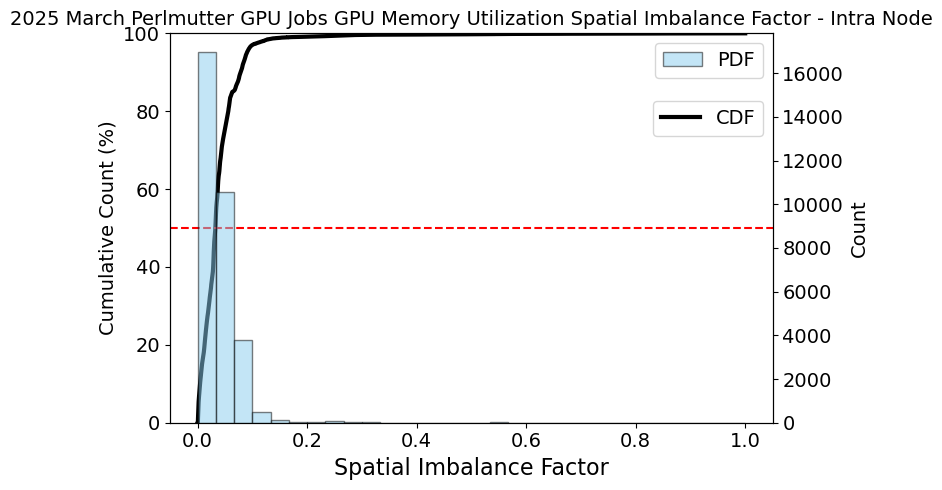

In [15]:
plot_sif_dist(vasp_data, 'mem_sif_intra_normalized', '2025 March Perlmutter GPU Jobs GPU Memory Utilization Spatial Imbalance Factor - Intra Node')
